In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms

%load_ext rpy2.ipython

In [4]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(hexbin)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In addition: Warning message:
package ‘ggnewscale’ was built under R version 4.3.3 


## Load Glasser parcellation for right hemisphere

In [5]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices.byteswap().newbyteorder()
glasser180_right_ctab = glasser180_right_ctab.byteswap().newbyteorder()
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Load overlapping community detection algorithm (OCDA) modules

In [7]:
# Read in OCDA modules
ocda_modules_glasser180_right = pd.read_csv("/Users/abry4213/github/OverlappingCommunityDetection_HCP/Results/table_of_modules_AF_renamed.csv")
ocda_modules_glasser180_right.columns = ["Glasser_RH_ROI", "module", "overlapping"]

# Load module orders
module_orders = pd.read_csv("module_order.csv")

In [8]:
%%R -i ocda_modules_glasser180_right,module_orders -o ocda_modules_glasser180_right

# Tidy data
ocda_modules_glasser180_right <- ocda_modules_glasser180_right %>% 
  mutate(module = factor(module, levels = module_orders$Module))%>% 
  filter(module != "Unassigned")

## Load Margulies 2016 principal gradient vertices

In [8]:
# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_principal_gradient = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_principal_gradient_fsaverage_right = transforms.fslr_to_fsaverage(margulies_principal_gradient, '164k', 'R')[0]
margulies_principal_gradient_fsaverage_right_vertices = margulies_principal_gradient_fsaverage_right.agg_data()

margulies_principal_gradient_fsaverage_right_df = pd.DataFrame({'PC1_value': margulies_principal_gradient_fsaverage_right_vertices, 
                                                                'vertex_number': np.arange(0, len(margulies_principal_gradient_fsaverage_right_vertices))})

## Merge all the data!

In [ ]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, ocda_modules_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_principal_gradient_fsaverage_right_df, on='vertex_number', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???"')

## How do overlapping vs. non-overlapping modules compare in the principal Margulies gradient?

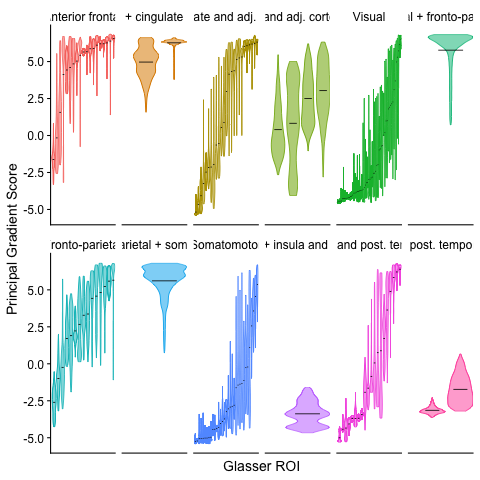

In [10]:
%%R -i merged_df 

# Voxelwise distributions
merged_df %>%
    filter(module != "Unassigned") %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, PC1_value, .fun=mean)) %>%
    mutate(module_fct = fct_reorder(module, PC1_value, .fun=mean)) %>%
    ggplot(data=., mapping=aes(x=Glasser_RH_ROI, y=PC1_value, fill=module, color=module)) +
    geom_violin(scale="width", position = position_nudge(x=0.25),
                linewidth=0.3, alpha=0.55) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.5, linewidth=0.15, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    ylab("Principal Gradient Score") +
    xlab("Glasser ROI") +
    facet_wrap(. ~ module, nrow=2, scales="free_x") +
    theme(legend.position = "none",
          strip.placement='outside',
          axis.ticks.x = element_blank(),
          strip.background = element_blank(),
          axis.text.x = element_blank())
# ggsave("../Plots/Modules_vs_Margulies_PC1_voxelwise.svg", width=13, height=4.5, units="in", dpi=300)

### Alternative violin plot with just the overlapping modules

In [11]:
%%R -i merged_df 

# Voxelwise distributions
merged_df %>%
    filter(module != "Unassigned" & overlapping == "Overlapping") %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, PC1_value, .fun=mean)) %>%
    mutate(module_fct = fct_reorder(module, PC1_value, .fun=mean)) %>%
    rowwise() %>%
    mutate(region_label = gsub("R_", "", str_split(Glasser_RH_ROI, "_ROI")[[1]][1])) %>%
    ggplot(data=., mapping=aes(x=region_label, y=PC1_value, fill=module, color=module)) +
    # geom_violin(scale="width", position = position_nudge(x=0.25),
    #             linewidth=0.7, alpha=0.85) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.95, alpha=0.85)  +
    geom_point(position = position_jitter(width = 0.1, height=0),
                            size = 1.5, alpha=0.4, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.35, linewidth=0.35, 
            show.legend=FALSE, position = position_nudge(x=0.25)) +
    xlab("Principal Gradient Score") +
    ylab("Overlapping ROI, Right Hemisphere") +
    coord_flip() +
    facet_grid(module_fct ~ ., space="free", scales="free_y", switch="both") +
    scale_fill_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                              "Cingulate and adj. cortex + visual" = "#7cae00",
                              "Visual + fronto-parietal" = "#00c08b",
                              "Fronto-parietal + somatomotor" = "#00b4f0",
                              "Somatomotor + insula and post. temporal" = "#c77cff",
                              "Insula and post. temporal + visual" = "#ff64b0")) +
    scale_color_manual(values=c("Anterior frontal + cingulate and adj. cortex" = "#de8c00",
                              "Cingulate and adj. cortex + visual" = "#7cae00",
                              "Visual + fronto-parietal" = "#00c08b",
                              "Fronto-parietal + somatomotor" = "#00b4f0",
                              "Somatomotor + insula and post. temporal" = "#c77cff",
                              "Insula and post. temporal + visual" = "#ff64b0")) +
    theme(legend.position = "none",
          strip.placement='outside',
          strip.text.y.left = element_text(angle=0),
          axis.text = element_text(size=15),
          strip.background = element_blank())
# ggsave("../Plots/Overlapping_Modules_vs_Margulies_PC1_voxelwise.svg", width=7.5, height=6, units="in", dpi=300)

## Neurosynth stuff

In [9]:
import Bio  # pip install biopython

from nimare.extract import download_abstracts, fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nimare.correct import FWECorrector
from nimare.dataset import Dataset
from nimare.meta.cbma.mkda import MKDADensity
from nilearn.plotting import plot_stat_map
from nilearn.maskers import NiftiLabelsMasker
from pprint import pprint
from scipy.io import savemat

In [10]:
# Download neurosynth data
out_dir = os.path.abspath("/Users/abry4213/data/") # Where to download data to
os.makedirs(out_dir, exist_ok=True)

# Takes Version 7 of Neurosynth, can be changed to preferred version
files = fetch_neurosynth(
    data_dir=out_dir,
    version="7",
    overwrite=False,
    source="abstract",
    vocab="LDA100",
) # can change vocab="terms" for individual neurosynth terms
# Note that the files are saved to a new folder within "out_dir" named "neurosynth".
pprint(files)
neurosynth_db = files[0]

INFO:nimare.extract.utils:Dataset found in /Users/abry4213/data/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('source-abstract', 'vocab-LDA100', 'data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
[{'coordinates': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_coordinates.tsv.gz',
  'features': [{'features': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_vocab-LDA100_source-abstract_type-weight_features.npz',
                'keys': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_vocab-LDA100_keys.tsv',
                'metadata': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_vocab-LDA100_metadata.json',
                'vocabulary': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_vocab-LDA100_vocabulary.txt'}],
  'metadata': '/Users/abry4213/data/neurosynth/data-neurosynth_version-7_metadata.tsv.gz'}]


In [ ]:
# Convert Neurosynth database to NiMARE dataset file
# In neurosynth_db, you can modify the files (features + vocabulary) used e.g. instead of using terms you can use LDA topics for annotations (features)
# data-neurosynth_version-7_vocab-LDA400_source-abstract_type-weight_features.npz for LDA400 Topics
# data-neurosynth_version-7_vocab-terms_source-abstract_type-tfidf_features.npz for individual terms
ns_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
)
# Save dataset without abstracts
ns_dset.save(os.path.join(out_dir, "neurosynth_dataset_LDA100.pkl.gz"))
print(ns_dset)


Dataset(14371 experiments, space='mni152_2mm')


In [ ]:
# Add article abstracts to dataset
ns_dset = download_abstracts(ns_dset, "anniegbryant@gmail.com") # Change to your uni email

# Save dataset with abstracts
ns_dset.save(os.path.join(out_dir, "neurosynth/neurosynth_dataset_LDA100_with_abstracts.pkl.gz"))

# How many studies in dataset
print(f"There are {len(ns_dset.ids)} studies in the Neurosynth database.")

INFO:nimare.extract.extract:Downloading chunk 1 of 16
INFO:nimare.extract.extract:Downloading chunk 2 of 16
INFO:nimare.extract.extract:Downloading chunk 3 of 16
INFO:nimare.extract.extract:Downloading chunk 4 of 16
INFO:nimare.extract.extract:Downloading chunk 5 of 16
INFO:nimare.extract.extract:Downloading chunk 6 of 16
INFO:nimare.extract.extract:Downloading chunk 7 of 16
INFO:nimare.extract.extract:Downloading chunk 8 of 16
INFO:nimare.extract.extract:Downloading chunk 9 of 16
INFO:nimare.extract.extract:Downloading chunk 10 of 16
INFO:nimare.extract.extract:Downloading chunk 11 of 16
INFO:nimare.extract.extract:Downloading chunk 12 of 16
INFO:nimare.extract.extract:Downloading chunk 13 of 16
INFO:nimare.extract.extract:Downloading chunk 14 of 16
INFO:nimare.extract.extract:Downloading chunk 15 of 16
INFO:nimare.extract.extract:Downloading chunk 16 of 16


There are 14371 studies in the Neurosynth database.


In [11]:
# Load neurosynth dataset
ns_dset = Dataset.load(f"{out_dir}/neurosynth/neurosynth_dataset_LDA100_with_abstracts.pkl.gz")

# Extract list of neurosynth features/terms
annotations_list = list(ns_dset.annotations)


In [12]:

start = 3 # First neurosynth term
ns_terms = annotations_list[start:]

# Save neurosynth terms as csv
ns_terms2 = pd.DataFrame(ns_terms)
ns_terms2.to_csv(f'{out_dir}/neurosynth/ns_terms.csv')

In [41]:
# Load in custom atlas (voltron)
atlas = nib.load('/Users/abry4213/data/neuroimaging_atlases/volumes/freesurfer_segmentations/mni152_space/atlas-desikankilliany.nii.gz') # path to custom atlas .nii.gz

# Create masker object - using voltron labels, z-score data
masker = NiftiLabelsMasker(labels_img=atlas)

In [13]:
i = 1
while i < len(ns_terms):
    if not os.path.exists(f"{out_dir}/neurosynth/nifti_volumes/meta_map_{ns_terms[i]}_montecarlo_10.nii.gz"):
        print(f"Iteration {i} out of {len(ns_terms)-1}...")
        msg = f'Running meta-analysis for term: {ns_terms[i]}'
        print(msg, end='\r', flush=True)
        temp_ids = ns_dset.get_studies_by_label(ns_terms[i])
        temp_dset = ns_dset.slice(temp_ids)
        print(f"\nThere are {len(temp_ids)} studies labeled with '{ns_terms[i]}'.")

        # Run Multilevel Kernel Density Analysis
        meta = MKDADensity()
        results = meta.fit(temp_dset)

        # Bonferroni multiple comparisons test
        # Available methods are 'montecarlo', 'bonferroni'
        corr = FWECorrector(method="montecarlo", n_iters=10, n_cores=4)
        cres = corr.transform(results)

        # Extract the meta-map
        meta_map = cres.get_map("z_level-voxel_corr-FWE_method-montecarlo")

        # save meta_Map to nifti
        nib.save(meta_map, f"{out_dir}/neurosynth/nifti_volumes/meta_map_{ns_terms[i]}_montecarlo_10.nii.gz")

        i += 1

Iteration 1 out of 99...
Running meta-analysis for term: LDA100_abstract_weight__1_gyrus_frontal_middle
There are 13703 studies labeled with 'LDA100_abstract_weight__1_gyrus_frontal_middle'.


KeyboardInterrupt: 